$$\textbf{Blatt 08 - Praktische Optimierung - Adrian Lentz, Robert Schönewald}$$

Lösungen und Erklärungen für Blatt 08. $$\newline$$
Adrian Lentz - Matrikelnummer: 258882 $$\newline$$
Robert Schönewald - Matrikelnummer: 188252

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.random.seed(0)

$$\textbf{Teil a}$$

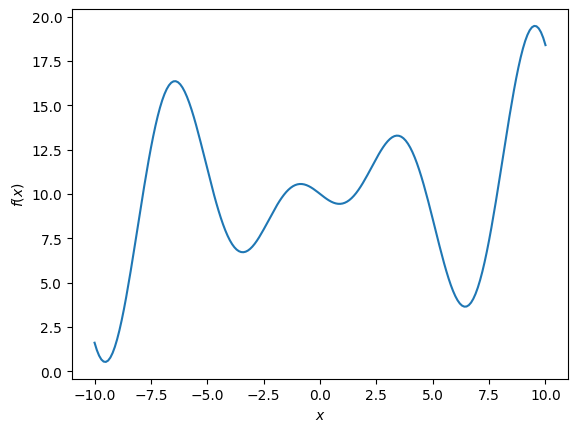

In [5]:
def true_fun(x):
    return 10 - x * np.cos(x)

LOWER = -10
UPPER = 10
N_Samples = 11
X_samples=np.linspace(LOWER,UPPER,N_Samples)
y_samples=true_fun(X_samples)

X = np.linspace(LOWER, UPPER, 201)  #201 äquidistante Stellen
plt.plot(X, true_fun(X), label="True function")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

plt.show()

$$\textbf{Polynomial Modell}$$

In [32]:
def make_poly_model(f, k, X_samples, y_samples):
    # Erstellung der Polynomialfeatures und Lineare Regression
    polynomial_features = PolynomialFeatures(degree=k, include_bias=True)
    linear_regression = LinearRegression()
    pipe = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    # Modell an den gegebenen Samples fitten
    pipe.fit(X_samples.reshape(-1,1), y_samples.reshape(-1,1))

    return lambda x: pipe.predict(np.array(x).reshape(-1,1)).flatten()


#Test 
#pred_fun = make_poly_model(true_fun, k=1) #k=1,2,5,10,15
#pred_fun(1)

In [41]:
degrees = [1,2,5,10,15] #k=1,2,5,10,15
NUM_OF_REPEATS = 1

pred_funcs = {}
for degree in degrees:
    pred_funcs[degree]=[]
    for _ in range(NUM_OF_REPEATS):
        pred_funcs[degree].append(make_poly_model(true_fun, k=degree, X_samples=X_samples, y_samples=y_samples))

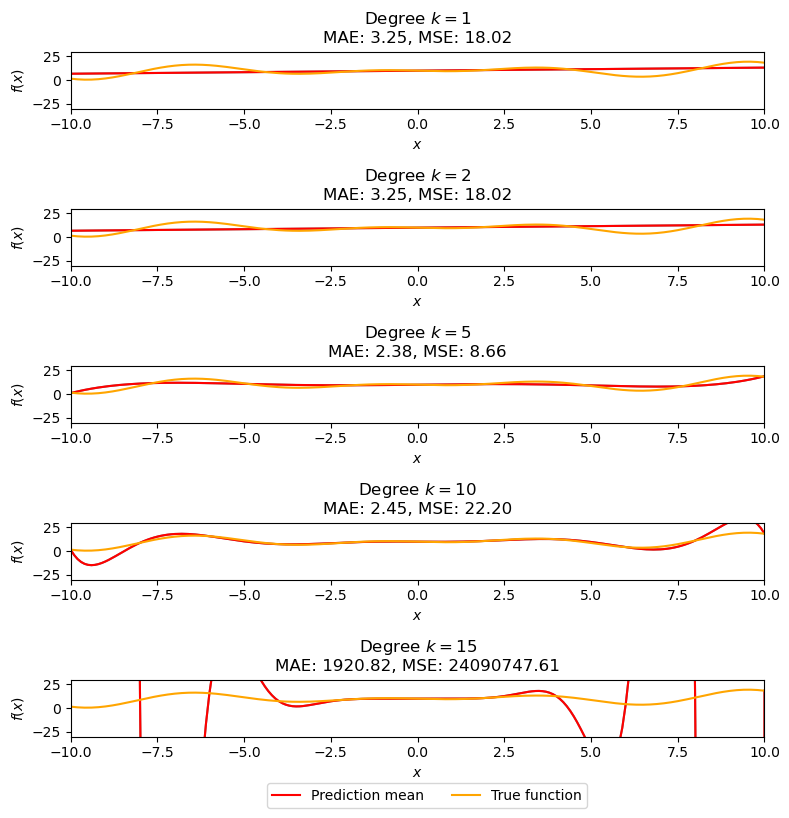

In [42]:
fig = plt.figure(figsize=(8, 8))

true_y = true_fun(X)
mean_y_k, vars_y_k = {}, {}

mse_scores, mae_scores = {},{}

for idx,degree in enumerate(degrees):
    plt.subplot(5,1,idx+1)
    
    # plot predicted functions
    pred_y = np.zeros((NUM_OF_REPEATS,len(X)))

    for i, pred_f in enumerate(pred_funcs[degree]):
        pred_y[i] = pred_f(X)
        plt.plot(X, pred_y[i], c="gray")#, label="Predicted function")
    
    # calculate mean and variance
    mean_y_k[degree] = np.mean(pred_y, axis=0)
    vars_y_k[degree] = np.var(pred_y, axis=0)

    # calculate MAE and MSE
    mae_scores[degree] = mean_absolute_error(true_y, mean_y_k[degree])
    mse_scores[degree] = mean_squared_error(true_y, mean_y_k[degree])
    
    # plot mean prediction
    plt.plot(X, mean_y_k[degree], color="red", label="Prediction mean"\
                                if degree == degrees[0] else None)
    
    # plot true function
    plt.plot(X, true_y, color="orange", label="True function"\
                            if degree == degrees[0] else None)
    
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.xlim((LOWER, UPPER))
    plt.ylim((-30,30))
    plt.title(f"Degree $k={degree}$\nMAE: {mae_scores[degree]:.2f}, MSE: {mse_scores[degree]:.2f}")
    
fig.legend(loc='lower center', bbox_to_anchor=(0.54, -0.025), ncol=2)

plt.tight_layout()
plt.show()

Werte des MSE können sehr stark varrieren, da MSE sehr empfindlich gegenüber Ausreißern ist. MAE (absolute Fehler) ist relativ robust, da nur absoluten Fehler betrachtet --> Außer für k=15 .

Degree 10:
Max Absolute Fehler: 15.33
Max Squared Fehler: 235.16


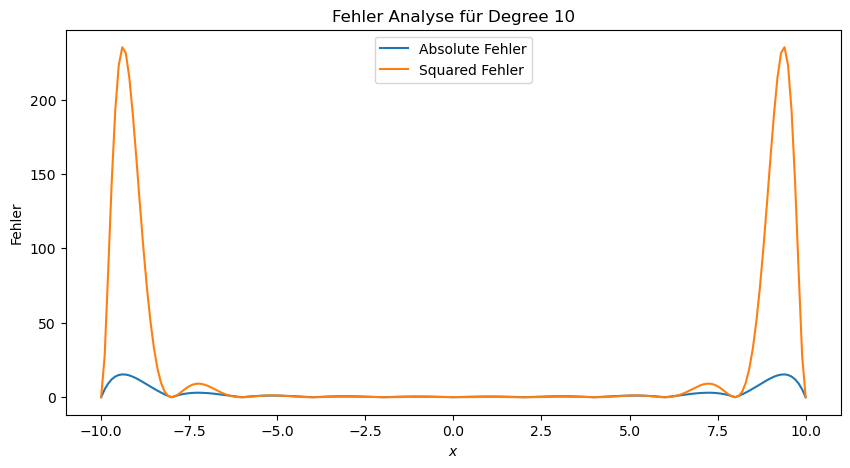

Degree 15:
Max Absolute Fehler: 17795.83
Max Squared Fehler: 316691514.59


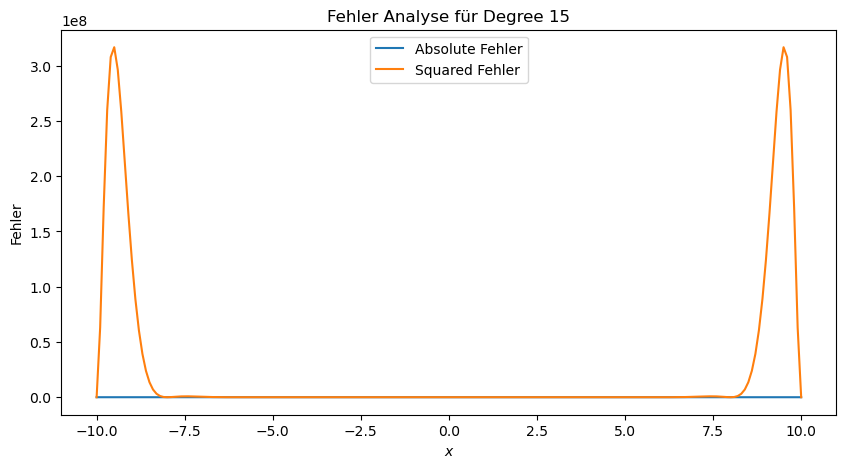

In [44]:
for degree in [10, 15]:
    errors = np.abs(mean_y_k[degree] - true_y)
    squared_errors = (mean_y_k[degree] - true_y) ** 2
    
    print(f"Degree {degree}:")
    print(f"Max Absolute Fehler: {np.max(errors):.2f}")
    print(f"Max Squared Fehler: {np.max(squared_errors):.2f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(X, errors, label="Absolute Fehler")
    plt.plot(X, squared_errors, label="Squared Fehler")
    plt.xlabel("$x$")
    plt.ylabel("Fehler")
    plt.title(f"Fehler Analyse für Degree {degree}")
    plt.legend()
    plt.show()

Man erkennt das die größten Fehler in den Randbereichen des Definitionsbereich von x auftreten, wobei insbesondere für k=10 der absolute Fehler noch stark ist, für k=15 sind die Fehler noch deutlich größer, sodass in der Abbildung die Fehler-Skalierung deutlich größer ist ! 
Sowohl der absolute und der quadratische Fehler sind für k=15 sehr groß.

$$\textbf{Kriging}$$

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared

In [2]:
'Kernels'
kernels = [
    RBF(),  #Radiale Basisfunktion 
    Matern(nu=0.5), #matern Kernel
    Matern(nu=1.5),
    Matern(nu=2.5),
    ExpSineSquared(periodicity=4), #Exp-sin-Square Kernel
    ExpSineSquared(periodicity=6),
    ExpSineSquared(periodicity=8)
]


In [19]:
'Test-Punkte'
X_test = np.linspace(-10, 10, 201).reshape(-1, 1)  # 201 Punkte
y_test = true_fun(X_test)

X_train = np.linspace(-10, 10, 11).reshape(-1, 1)  # 11 äquidistante Punkte
y_train = true_fun(X_train).ravel()  # Funktion an den Trainingspunkten auswerten

c:\Users\Adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


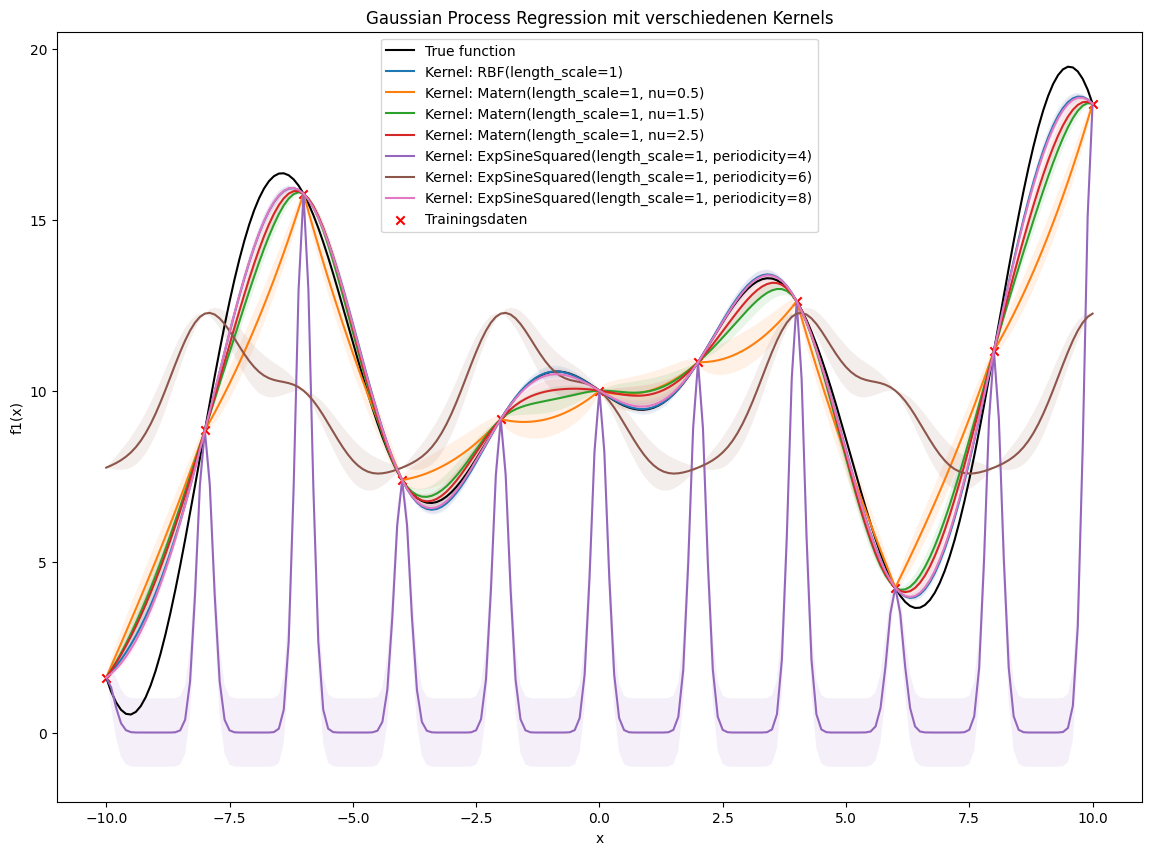

In [20]:
'Graphische Darstellung der verschiedenen Kernels'

plt.figure(figsize=(14, 10))
plt.plot(X_test, y_test, 'k', label='True function')

for kernel in kernels:
    # Modell initialisieren
    gpr = GaussianProcessRegressor(kernel=kernel)
    # Modell an Trainingsdaten anpassen
    gpr.fit(X_train, y_train)
    # Vorhersagen machen
    y_pred, sigma = gpr.predict(X_test, return_std=True)
    # Ergebnisse plotten
    plt.plot(X_test, y_pred, label=f'Kernel: {kernel}')
    plt.fill_between(X_test.ravel(), y_pred - sigma, y_pred + sigma, alpha=0.1)

plt.scatter(X_train, y_train, c='r', marker='x', label='Trainingsdaten')
plt.title('Gaussian Process Regression mit verschiedenen Kernels')
plt.xlabel('x')
plt.ylabel('f1(x)')
plt.legend()
plt.show()

Man erkennt die deutlichen Unterschiede zwischen den verschiedenen verwendenten Kernel Varianten:

Der Exp-Sin-Kernel sind zwei der drei Varianten (p=4,6)(braun,violett) sehr schlecht, in Bezug auf die Funktion (schwarz).

Die Kernel Varianten der radialen Basisfunktionen und des Matern Kernel erzeugen visuell gute Ergebnisse, wobei keine direkten Unterschiede klar zu erkennen sind.

Um eine bessere Bewertung vorzunehmen, werden anschließend die mittlere absolute Abweichung und die mittlere quadratische Abweichung betrachtet, wodurch auch ein Vergleich zum Polynomiellen Modell möglich ist.

In [21]:
results = {}

# Gaussian Process Modelle trainieren, vorhersagen und Abweichungen berechnen
for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(X_train, y_train)
    y_pred, sigma = gpr.predict(X_test, return_std=True)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results[str(kernel)] = {'MAE': mae, 'MSE': mse}
    print(f'Kernel: {kernel}\nMAE: {mae:.4f}\nMSE: {mse:.4f}\n')


Kernel: RBF(length_scale=1)
MAE: 0.4110
MSE: 0.4527

Kernel: Matern(length_scale=1, nu=0.5)
MAE: 1.2263
MSE: 2.7305

Kernel: Matern(length_scale=1, nu=1.5)
MAE: 0.7384
MSE: 1.0662

Kernel: Matern(length_scale=1, nu=2.5)
MAE: 0.6098
MSE: 0.7885

Kernel: ExpSineSquared(length_scale=1, periodicity=4)
MAE: 7.9667
MSE: 88.7055

Kernel: ExpSineSquared(length_scale=1, periodicity=6)
MAE: 3.4577
MSE: 18.1311

Kernel: ExpSineSquared(length_scale=1, periodicity=8)
MAE: 0.4122
MSE: 0.4359



c:\Users\Adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [22]:
#Bestes/Schlechtetes  Modell
best_kernel = min(results, key=lambda k: results[k]['MAE'])
worst_kernel = max(results, key=lambda k: results[k]['MAE'])
print(f'Bestes Modell basierend auf MAE: {best_kernel} mit MAE: {results[best_kernel]["MAE"]:.4f} und MSE: {results[best_kernel]["MSE"]:.4f}')    
print(f'Schlechtestes Modell basierend auf MAE: {worst_kernel} mit MAE: {results[worst_kernel]["MAE"]:.4f} und MSE: {results[worst_kernel]["MSE"]:.4f}')   

Bestes Modell basierend auf MAE: RBF(length_scale=1) mit MAE: 0.4110 und MSE: 0.4527
Schlechtestes Modell basierend auf MAE: ExpSineSquared(length_scale=1, periodicity=4) mit MAE: 7.9667 und MSE: 88.7055


Durch die Betrachtung der mittleren Abweichung bestätigt sich die visuelle Vermutung, der radiale Basisfunktion Kernel schneidet am besten ab, hingegen der Exp-Sin Kernel mit p=4 am schlechtesten ist.